Sales Forecasting
#2. Univariate modeling
## 2-3. ARIMA

In [51]:
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import plotly.express as px

from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
data_path = "/content/drive/MyDrive/github_repo/time-series-study/data"

In [3]:
train = pd.read_csv(os.path.join(data_path, "train.csv"))
test = pd.read_csv(os.path.join(data_path, "test.csv"))

In [4]:
def plot_by_family(df:pd.DataFrame, store_id:int, categories:list=[], return_data:bool=False):
  if len(categories) == 0:
    df = df.loc[df.store_nbr==store_id, ][["date", "family", "sales"]]
  else:
    df = df.loc[(df.store_nbr==store_id) & (df.family.isin(categories)), ][["date", "family", "sales"]]
  df = pd.pivot(df, index=["date"], columns = "family", values = "sales").reset_index()

  fig = px.line(df, x="date", y=df.columns,
                hover_data={"date": "|%B %d, %Y"},
                title='sales time series')
  fig.update_xaxes(
      dtick="M1",
      tickformat="%b\n%Y")
  fig.show()
  return df if return_data else None

In [5]:
TARGET = "FROZEN FOODS" # ["LAWN AND GARDEN", "EGGS", "BEAUTY", "AUTOMOTIVE", "BOOKS", "FROZEN FOODS", "GROCERY I"]

In [6]:
train_df = plot_by_family(train, 44, [TARGET], True)

## 1) Test of Stationarity (정상성 확인)

* 참고사이트: https://leedakyeong.tistory.com/entry/Python-%EB%82%A0%EC%94%A8-%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%8D%B0%EC%9D%B4%ED%84%B0Kaggle%EB%A1%9C-ARIMA-%EC%A0%81%EC%9A%A9%ED%95%98%EA%B8%B0

In [13]:
lag = 20

* 연단위의 seasonality가 있어보이는 데이터지만 ACF를 보았을 때 lag 15 이후, PACF는 lag 3 지점에서 수렴해보임
* Augmented Dicky-Fuller Test 결과도 p-value가 작아 귀무가설 기각하여 정상성이 있다고 판단
  - H0: 정상성 만족하지 않음 vs. H1: 정상정 만족

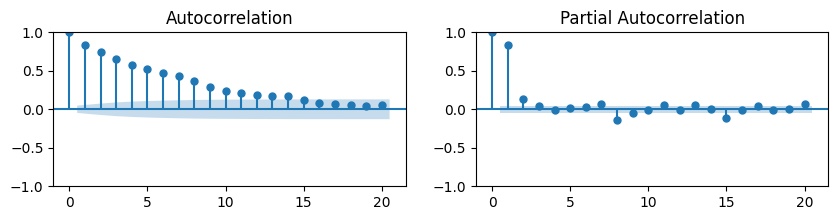

In [41]:
fig = plt.Figure(figsize = (10, 2))
ax1 = fig.add_subplot(121)
sm.graphics.tsa.plot_acf(train_df[TARGET], lags=lag, ax=ax1)

ax2 = fig.add_subplot(122)
sm.graphics.tsa.plot_pacf(train_df[TARGET], lags=lag, ax=ax2)

In [14]:
adf_test = adfuller(train_df[TARGET])

In [16]:
print(f'statistics: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

statistics: -7.1347754018087
p-value: 3.4436854295251395e-10


* 정상성 만족하지만 1차 차분 후 결과를 살펴보고자함
* 1차 차분했을 때 ACF 기준 수렴이 더욱 빠름을 확인, ADF test도 유의

In [18]:
diff = train_df[TARGET] - train_df[TARGET].shift()

<Axes: >

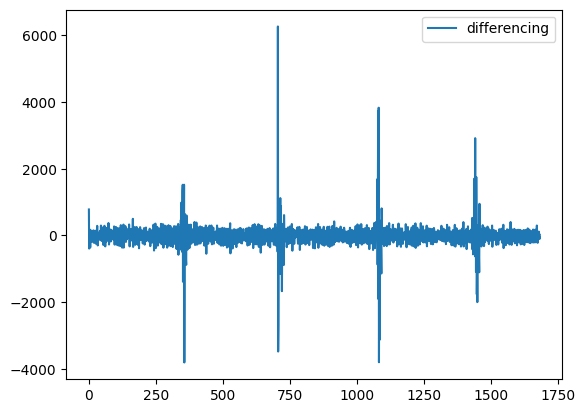

In [19]:
diff.plot(legend=True, label='differencing')

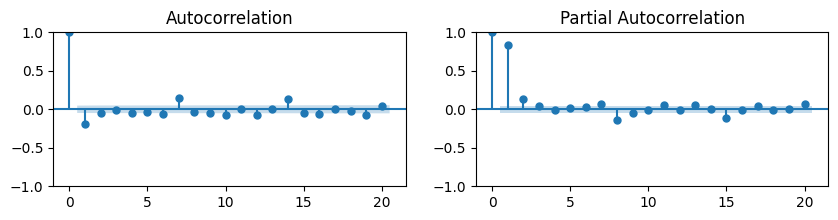

In [42]:
fig = plt.Figure(figsize = (10, 2))
ax1 = fig.add_subplot(121)
sm.graphics.tsa.plot_acf(diff[1:], lags=lag, ax=ax1)

ax2 = fig.add_subplot(122)
sm.graphics.tsa.plot_pacf(train_df[TARGET], lags=lag, ax=ax2)

In [21]:
diff_adf_test = adfuller(diff[1:])
print(f'statistics: {diff_adf_test[0]}')
print(f'p-value: {diff_adf_test[1]}')

statistics: -11.85810537543949
p-value: 6.9500805241953565e-22


## 2) ARIMA Fitting

In [25]:
valid_ratio = 0.7

In [26]:
train_period = int(train_df.shape[0]*valid_ratio)
trains = train_df.iloc[:train_period]
valids = train_df.iloc[train_period:]

trains.shape, valids.shape

((1178, 2), (506, 2))

In [43]:
model1 = ARIMA(trains[TARGET], order=(3, 0, 15))
model2 = ARIMA(trains[TARGET], order=(3, 1, 2))

In [44]:
model1_fitted = model1.fit()
model2_fitted = model2.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [45]:
model1_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           FROZEN FOODS   No. Observations:                 1178
Model:                ARIMA(3, 0, 15)   Log Likelihood               -8644.329
Date:                Tue, 06 Jun 2023   AIC                          17328.659
Time:                        10:13:06   BIC                          17430.090
Sample:                             0   HQIC                         17366.902
                               - 1178                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        616.2636    211.388      2.915      0.004     201.950    1030.577
ar.L1          0.5122      0.051      9.954      0.000       0.411       0.613
ar.L2         -0.5556      0.026    -20.989      0.000      -0.608      -0.504
ar.L3          0.9552      0.051     18.849      0.000       0.856       1.055
ma.L1          0.2113      0.052      4.032      0.000       0.109       0.314
ma.L2          0.8642      0.062     13.879      0.000       0.742       0.986
ma.L3         -0.3248      0.102     -3.175      0.001      -0.525      -0.124
ma.L4         -0.1618      0.083     -1.941      0.052      -0.325       0.002
ma.L5         -0.1380      0.073     -1.883      0.060      -0.282       0.006
ma.L6         -0.1642      0.067     -2.448      0.014      -0.296      -0.033
ma.L7         -0.0110      0.062     -0.177      0.860      -0.133       0.111
ma.L8         -0.0578      0.063     -0.916      0.360      -0.181       0.066
ma.L9          0.0210      0.062      0.341      0.733      -0.100       0.142
ma.L10        -0.1283      0.057     -2.269      0.023      -0.239      -0.017
ma.L11        -0.1035      0.046     -2.243      0.025      -0.194      -0.013
ma.L12        -0.1717      0.053     -3.261      0.001      -0.275      -0.068
ma.L13        -0.0478      0.040     -1.195      0.232      -0.126       0.031
ma.L14        -0.0016      0.031     -0.052      0.958      -0.062       0.059
ma.L15         0.0059      0.031      0.192      0.848      -0.054       0.066
sigma2      1.482e+05   1788.522     82.859      0.000    1.45e+05    1.52e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            542737.88
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.86   Skew:                             5.93
Prob(H) (two-sided):                  0.00   Kurtosis:                       107.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
model2_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           FROZEN FOODS   No. Observations:                 1178
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -8682.801
Date:                Tue, 06 Jun 2023   AIC                          17377.603
Time:                        10:13:06   BIC                          17408.027
Sample:                             0   HQIC                         17389.074
                               - 1178                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1411      0.072     -1.957      0.050      -0.282       0.000
ar.L2          0.7162      0.055     13.139      0.000       0.609       0.823
ar.L3          0.1431      0.011     13.514      0.000       0.122       0.164
ma.L1         -0.1442      0.073     -1.976      0.048      -0.287      -0.001
ma.L2         -0.8558      0.074    -11.540      0.000      -1.001      -0.710
sigma2      1.491e+05    1.3e-07   1.15e+12      0.000    1.49e+05    1.49e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            437814.42
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                             5.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        96.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.81e+27. Standard errors may be unstable.
"""

In [47]:
preds1 = model1_fitted.forecast(steps=valids.shape[0])
preds2 = model2_fitted.forecast(steps=valids.shape[0])

<Axes: >

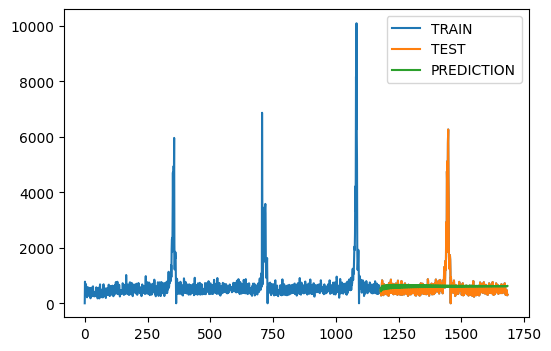

In [48]:
train_df[TARGET].plot(legend=True, label='TRAIN')
valids[TARGET].plot(legend=True, label='TEST',figsize=(6,4))
preds1.plot(legend=True, label='PREDICTION')

<Axes: >

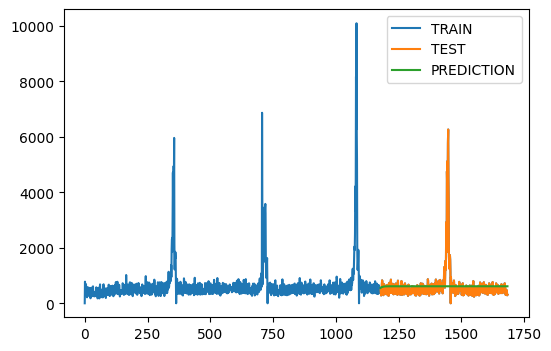

In [49]:
train_df[TARGET].plot(legend=True, label='TRAIN')
valids[TARGET].plot(legend=True, label='TEST',figsize=(6,4))
preds2.plot(legend=True, label='PREDICTION')

<Axes: >

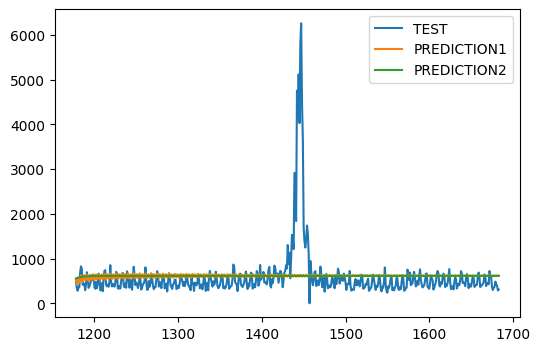

In [50]:
valids[TARGET].plot(legend=True, label='TEST',figsize=(6,4))
preds1.plot(legend=True, label='PREDICTION1')
preds2.plot(legend=True, label='PREDICTION2')

## 3) SARIMA (Seasonality 추가)

In [127]:
sarima_model = SARIMAX(trains[TARGET], order=(3, 1, 2), season_order=(3, 1, 2, 360))
sarima_model_fitted = sarima_model.fit(maxiter=50)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [128]:
sarima_model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           FROZEN FOODS   No. Observations:                 1178
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -8682.801
Date:                Tue, 06 Jun 2023   AIC                          17377.603
Time:                        10:30:36   BIC                          17408.027
Sample:                             0   HQIC                         17389.074
                               - 1178                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1411      0.072     -1.957      0.050      -0.282       0.000
ar.L2          0.7162      0.055     13.139      0.000       0.609       0.823
ar.L3          0.1431      0.011     13.514      0.000       0.122       0.164
ma.L1         -0.1442      0.073     -1.976      0.048      -0.287      -0.001
ma.L2         -0.8558      0.074    -11.540      0.000      -1.001      -0.710
sigma2      1.491e+05    1.3e-07   1.15e+12      0.000    1.49e+05    1.49e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            437814.42
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                             5.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        96.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.81e+27. Standard errors may be unstable.
"""

In [129]:
sarima_preds = sarima_model_fitted.forecast(steps=valids.shape[0])

<Axes: >

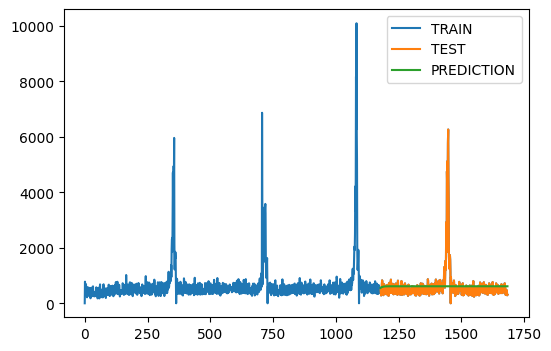

In [130]:
train_df[TARGET].plot(legend=True, label='TRAIN')
valids[TARGET].plot(legend=True, label='TEST',figsize=(6,4))
sarima_preds.plot(legend=True, label='PREDICTION')

<Axes: >

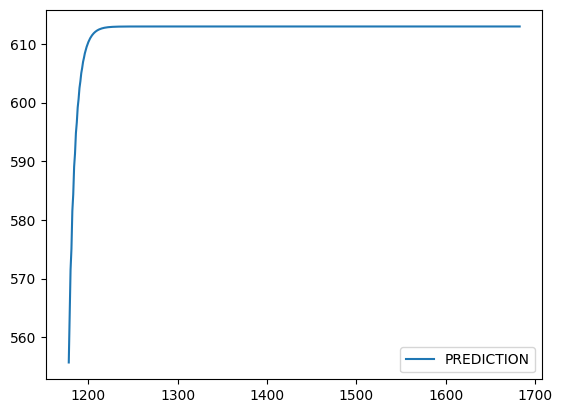

In [131]:
sarima_preds.plot(legend=True, label='PREDICTION')